# 4. Mushroom foraging

The [mushroom dataset](https://www.kaggle.com/datasets/dhinaharp/mushroom-dataset) contains data about approximately 60000 mushrooms, and your task is to classify them as either edible or poisonous. You can read about the features [here](https://www.kaggle.com/datasets/uciml/mushroom-classification) and import the data using:

In [12]:
import pandas as pd
pd.set_option('display.max_columns', 1000)
df = pd.read_csv('secondary_data.csv', delimiter = ';')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


It's up to you how you approach this data, but at a minimum, your analysis should include:

* Informed **data preparation**.
* 2 different classification models, one of which must be **logistic regression**.
* A discussion of which **performance metric** is most relevant for the evaluation of your models.
* 2 different **validation methodologies** used to tune hyperparameters.
* **Confusion matrices** for your models, and associated comments.

### Informed **data preparation**. +  2 different classification models, one of which must be **logistic regression**.

LOGISTIC REGRESSION
Samples: 61069
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      6785
           1       0.81      0.82      0.81      5429

    accuracy                           0.83     12214
   macro avg       0.83      0.83      0.83     12214
weighted avg       0.83      0.83      0.83     12214



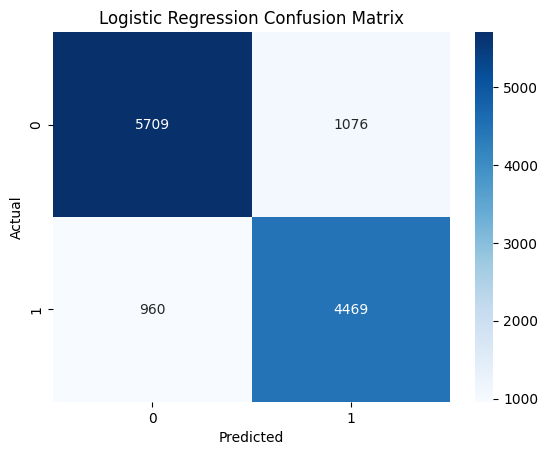

Cross-validation scores: [0.46438513 0.54986082 0.56467988 0.6543311  0.70244821]
Average CV accuracy: 0.5871410258426547
RANDOM FOREST
Samples: 61069
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6785
           1       1.00      1.00      1.00      5429

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



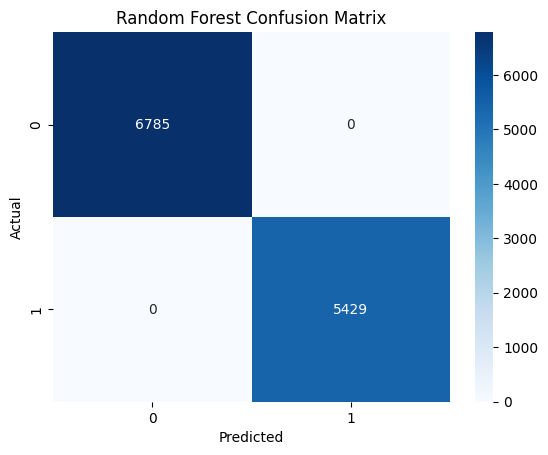

Cross-validation scores: [0.54871459 0.52873751 0.63910267 0.53938104 0.7311062 ]
Average CV accuracy: 0.5974084019354562


In [13]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Getting data from the csv
pd.set_option('display.max_columns', 1000)
df = pd.read_csv('secondary_data.csv', delimiter = ';')

#We use ratioed distrubution because the dataset have a lot of NaN's and that does not go well with the models.
def ratioed_distribution(property_name):
    non_null_values = df[property_name].dropna()
    # Probability distribution
    value_counts = non_null_values.value_counts(normalize=True)  

    nan_count = df[property_name].isna().sum()

    # Generate samples for NaN values while maintaining distribution
    sampled_values = np.random.choice(value_counts.index, size=nan_count, p=value_counts.values)

    df.loc[df[property_name].isna(), property_name] = sampled_values

    new_value_counts = df[property_name].value_counts(normalize=True)

    error_margin = 0.01
    valid = all(abs(new_value_counts - value_counts) <= error_margin)

#For one-hot.
columns_to_encode = [
     "cap-shape", "cap-surface", "cap-color", "gill-attachment",
    "gill-spacing", "gill-color", "stem-root", "stem-surface", "stem-color",
    "veil-type", "veil-color", "ring-type", "spore-print-color", "habitat", "season"
]

#Used to tanform the "p" and "e" to "1" and "0".
mapping = {'e': 1, 'p': 0}
df['class'] = df['class'].map(mapping)

#Changes other letter data to 0 and 1.
df["does-bruise-or-bleed"] = df["does-bruise-or-bleed"].map({"t": 1, "f": 0}).astype(int)
df["has-ring"] = df["has-ring"].map({"t": 1, "f": 0}).astype(int)

#Onehot, because else there could be a diffrence numerical value that result in some of the data being ignored.
df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

#Isolate lables
X = df_encoded.drop(columns=["class"])
y = df["class"]

#Splitting data to train and test set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


# Logistic regression
lr_model = LogisticRegression(max_iter=100000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print("LOGISTIC REGRESSION")
print(f"Samples: {df.shape[0]}")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

scores = cross_val_score(lr_model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average CV accuracy:", np.mean(scores))

# Random forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("RANDOM FOREST")
print(f"Samples: {df.shape[0]}")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average CV accuracy:", np.mean(scores))


DECISION TREE
Samples: 61069
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6785
           1       1.00      1.00      1.00      5429

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



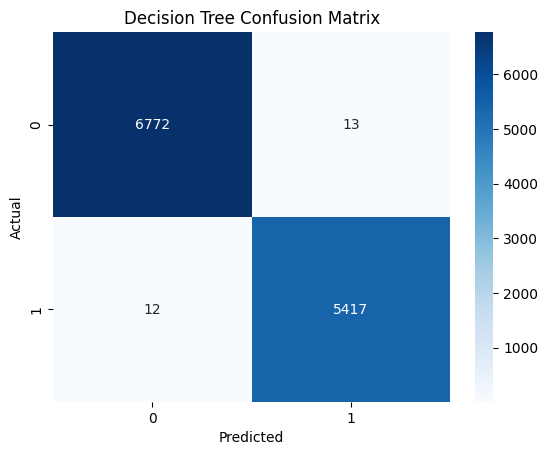

Decision Tree Cross-validation scores: [0.50221058 0.52783691 0.53561487 0.51023416 0.59141898]
Average Decision Tree CV accuracy: 0.533463098394953


In [14]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("DECISION TREE")
print(f"Samples: {df.shape[0]}")
print(classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

from sklearn.model_selection import cross_val_score
dt_scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')
print("Decision Tree Cross-validation scores:", dt_scores)
print("Average Decision Tree CV accuracy:", np.mean(dt_scores))


K-NEAREST NEIGHBORS
Samples: 61069
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6785
           1       1.00      1.00      1.00      5429

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



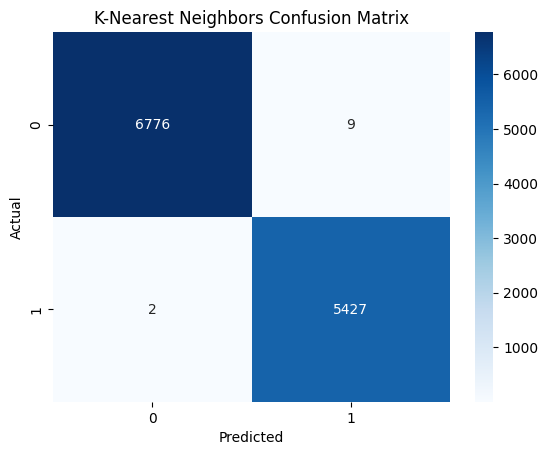

K-Nearest Neighbors Cross-validation scores: [0.43900442 0.47380056 0.57966268 0.49762568 0.69286826]
Average K-Nearest Neighbors CV accuracy: 0.5365923181309176


In [15]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

print("K-NEAREST NEIGHBORS")
print(f"Samples: {df.shape[0]}")
print(classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("K-Nearest Neighbors Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

from sklearn.model_selection import cross_val_score
knn_scores = cross_val_score(knn_model, X, y, cv=5, scoring='accuracy')
print("K-Nearest Neighbors Cross-validation scores:", knn_scores)
print("Average K-Nearest Neighbors CV accuracy:", np.mean(knn_scores))


GRADIENT BOOSTED TREES
Samples: 61069
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6785
           1       0.91      0.92      0.91      5429

    accuracy                           0.92     12214
   macro avg       0.92      0.92      0.92     12214
weighted avg       0.92      0.92      0.92     12214



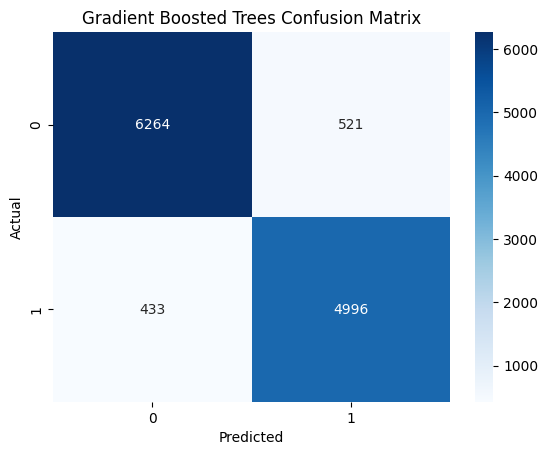

Gradient Boosted Trees Cross-validation scores: [0.5566563  0.57499591 0.63844768 0.52980187 0.73487268]
Average Gradient Boosted Trees CV accuracy: 0.6069548857487581


In [16]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

gbt_model = GradientBoostingClassifier(random_state=42)
gbt_model.fit(X_train, y_train)

y_pred_gbt = gbt_model.predict(X_test)

print("GRADIENT BOOSTED TREES")
print(f"Samples: {df.shape[0]}")
print(classification_report(y_test, y_pred_gbt))

cm_gbt = confusion_matrix(y_test, y_pred_gbt)
sns.heatmap(cm_gbt, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Gradient Boosted Trees Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

from sklearn.model_selection import cross_val_score
gbt_scores = cross_val_score(gbt_model, X, y, cv=5, scoring='accuracy')
print("Gradient Boosted Trees Cross-validation scores:", gbt_scores)
print("Average Gradient Boosted Trees CV accuracy:", np.mean(gbt_scores))


### A discussion of which **performance metric** is most relevant for the evaluation of your models.

In this context, **precision is the most critical performance metric** because it measures the proportion of true positives among all predicted positives, thereby evaluating the number of false positives. This is particularly important since a false positive (i.e., incorrectly identifying a poisonous mushroom as edible) could have fatal consequences.

Recall, on the other hand, is less relevant in this scenario. While it's undesirable to misclassify a healthy mushroom as poisonous, the consequences of doing so are relatively minor (i.e., simply not eating a safe mushroom). In contrast, the risk of eating a poisonous mushroom outweighs the potential loss of missing out on a few edible ones.

The F1 score, which balances precision and recall, is also less focused on minimizing false positives, which are the primary concern in this case. Therefore, while the F1 score provides a general idea of the model's performance, precision is a more suitable metric for evaluating the model's ability to avoid false positives and ensure safe mushroom identification.

***Random forest performance***

| ✅ Check                        | 🔎 Why It Matters                                |
| ------------------------------ | ------------------------------------------------ |
| Cross-validation               | Ensures model generalizes across splits          |
| Feature importance             | Detects overreliance or leakage                  |
| Imputation bias                | Validates the sampling isn’t distorting the data |
| Simpler model / fewer features | Tests whether simpler logic is sufficient        |
| Holdout validation             | Guarantees true out-of-sample testing            |


### 2 different **validation methodologies** used to tune hyperparameters.

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Parameters for Gridsearch
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [400, 500, 600, 700, 800, 900, 1000]
}

# Stratified K-Folds
skf = StratifiedKFold(n_splits=5)

# GridSearchCV with precision scoring
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=skf, n_jobs=-1, verbose=1 , scoring='precision')
grid_search.fit(X_train, y_train)

# Save and predict
best_lr_model = grid_search.best_estimator_
y_pred_lr_val = best_lr_model.predict(X_val)
y_pred_lr_test = best_lr_model.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("Validation set classification report:")
print(classification_report(y_val, y_pred_lr_val))
print("Test set classification report:")
print(classification_report(y_test, y_pred_lr_test))

Fitting 5 folds for each of 56 candidates, totalling 280 fits


Best parameters: {'C': 0.1, 'max_iter': 400, 'penalty': 'l2', 'solver': 'liblinear'}
Validation set classification report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      6819
           1       0.82      0.83      0.82      5395

    accuracy                           0.84     12214
   macro avg       0.84      0.84      0.84     12214
weighted avg       0.84      0.84      0.84     12214

Test set classification report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      6785
           1       0.81      0.82      0.81      5429

    accuracy                           0.83     12214
   macro avg       0.83      0.83      0.83     12214
weighted avg       0.83      0.83      0.83     12214



We use one validation method to cross validation to test for best hyperparameters

We use one validation method to see performance increase/decrese of these picked hyperparameters

We use both stratified K-forld and gridsearch to hypertune the logistc regression model.

### **Confusion matrices** for your models, and associated comments.

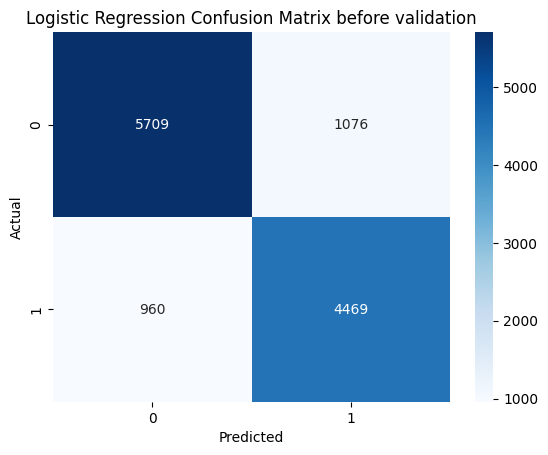

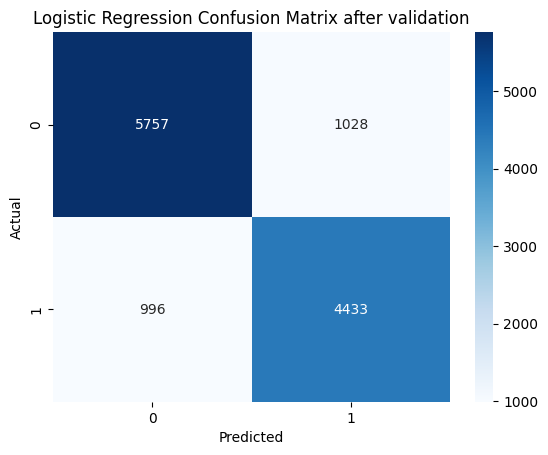

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Logistic Regression Confusion Matrix before validation")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm_lr = confusion_matrix(y_test, y_pred_lr_test)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Logistic Regression Confusion Matrix after validation")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**For logistic regression:**

The tuned model maintained an accuracy of 84%, which is consistent with the performance observed before tuning. This indicates that the model was already well-optimized, and the tuning process helped refine its performance without sacrificing accuracy.
Although precision is less servere it still got improved by 1% going from 86% to 87%
Even though recall remained the same at 83%, the confusion matrix shows a slight improvment in fewer false negatives.

**For random forest:** 

While a 100% accuracy is impressive, it raises concerns about overfitting. The model may have learned the training data too well, including noise and outliers, which can lead to poor generalization on unseen data. It is essential to validate this model on a separate validation set or through cross-validation to ensure it performs well on new data.